## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: It's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious  scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
classification_report, plot_roc_curve, roc_auc_score, accuracy_score,\
recall_score, precision_score

In [2]:
df = pd.read_csv('chronic_kidney_disease_full.csv')

In [3]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [4]:
df.shape

(400, 25)

In [5]:
df.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer: The basic features that use for screening the CKD are blood urea and serum creatinine.

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [6]:
# Check missing value
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

In [7]:
df_drop_all = df.dropna()
print(f'If I drop all missing value in dataframe, the remaining row is {df_drop_all.shape[0]} rows')

If I drop all missing value in dataframe, the remaining row is 158 rows


Answer: The remaining row is 158 rows. The result from drop missing value in this way isn't good because
- We waste all of the informative rows for machine learning.
- The remaining data is not enough for building good model.
- The missing data from gathered data may be missing not a random because doctor and nurse don't want to collect the the bad information of patient. 

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer: 
- The data, that collect in the ordinal, is depended on each doctors and nurses. The ordinal data in this dataset is albumine and sugar.
- The data, that collect in the nominal, is depended on doctors and nurse just like ordinal data.
- The patient may not follow the rule before measuring some of the value e.g., patient isn't fasting before measuring the blood sugar. 

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has chronic kidney disease (CKD) will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer: The models that predict all patients have chronic kidney disease.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: In this case, we minimize false negative.

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer: The person who doesn't have CKD will be told that they have CKD. They may depress and come up with another bad decision in the treatment.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer: The models that predict all patients don't have chronic kidney disease.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: We minimize false positive.

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: The person who has CKD will not be treat in the way they required. They may die because they don't receive treatment correctly.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [8]:
# Check % missing value --> # missing value/ total rows
(df.isnull().sum()/df.shape[0]).sort_values(ascending = False)

rbc      0.3800
rbcc     0.3275
wbcc     0.2650
pot      0.2200
sod      0.2175
pcv      0.1775
pc       0.1625
hemo     0.1300
su       0.1225
sg       0.1175
al       0.1150
bgr      0.1100
bu       0.0475
sc       0.0425
bp       0.0300
age      0.0225
ba       0.0100
pcc      0.0100
htn      0.0050
dm       0.0050
cad      0.0050
appet    0.0025
pe       0.0025
ane      0.0025
class    0.0000
dtype: float64

In [9]:
# Drop columns that have missing value greater than 20%
df = df.drop(columns = ['rbc','rbcc','wbcc','pot','sod'])

In [10]:
# Impute all missing value in numeric column with value of '0'
num_col = df.select_dtypes(exclude='object').columns
for col in num_col:
    df[col] = df[col].fillna(0)

In [11]:
obj_col = df.select_dtypes(include='object').columns
obj_col

Index(['pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class'], dtype='object')

In [12]:
# Mapping objective feature
# Column set1: pus cell(pc)
df['pc'] = df['pc'].map({'normal':0, 'abnormal':1})

# Feature set2: Pus Cell clumps, Bacteria(pcc, ba)
dict_s2 = {'present': 0, 'notpresent': 1}
list_s2 = ['pcc', 'ba']
for col in list_s2:
    df[col] = df[col].map(dict_s2)

# Feature set3: Hypertension, Diabetes Mellitus, Coronary Artery Disease
# Pedal Edema, Anemia (htn, dm, cad, pe, ane)
dict_s3 = {'yes': 1,'no': 0}
list_s3 = ['htn', 'dm', 'cad', 'pe', 'ane']
for col in list_s3:
    df[col] = df[col].map(dict_s3)
    
# Feature set4: Appetite (appet)
df['appet'] = df['appet'].map({'good':0, 'poor':1})

# Target variable
df['class'] = df['class'].map({'ckd':1, 'notckd':0})

In [13]:
# Impute all missing value with value of 0
# All of missing value 
df = df.fillna(0)

In [14]:
# Check missing value
df.isnull().sum()[df.isnull().sum() != 0]

Series([], dtype: int64)

In [15]:
# Check for type in df
df.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
pc       float64
pcc      float64
ba       float64
bgr      float64
bu       float64
sc       float64
hemo     float64
pcv      float64
htn      float64
dm       float64
cad      float64
appet    float64
pe       float64
ane      float64
class      int64
dtype: object

In [16]:
# Set X and y for training logistic regression model
X = df.drop('class', axis=1)
y = df['class']

# Split data: X before y, train before test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42)

In [17]:
# check our y_train
y_train.value_counts(normalize=True)

1    0.616667
0    0.383333
Name: class, dtype: float64

In [18]:
# check our y_test
y_test.value_counts(normalize=True)

1    0.65
0    0.35
Name: class, dtype: float64

In [19]:
# Instantiate
logreg = LogisticRegression(penalty='none', max_iter= 400)

# Fit or train model
logreg.fit(X_train,y_train)

# Scoring the model
print(f'Training accuracy: {round(logreg.score(X_train,y_train),4)}')
print(f'Testing accuracy: {round(logreg.score(X_test,y_test),4)}')

y_preds = logreg.predict(X_test)
print(confusion_matrix(y_test,y_preds))
print(classification_report(y_test, y_preds))

Training accuracy: 0.97
Testing accuracy: 0.99
[[35  0]
 [ 1 64]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       1.00      0.98      0.99        65

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [20]:
X.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc',
       'hemo', 'pcv', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'],
      dtype='object')

In [21]:
coef_df = pd.DataFrame(logreg.coef_[0], index = X.columns,columns = ['Coefficient'])

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [22]:
coef_df

,Coefficient
age,-0.038559
bp,0.015261
sg,-2.235578
al,223.397588
su,75.015209
pc,160.929133
pcc,0.511724
ba,5.734637
bgr,0.000615
bu,-0.072817


In [23]:
num_col

Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'hemo', 'pcv'], dtype='object')

In [24]:
# Interpret coefficient of Hemoglobin ('hemo')
round(np.exp(coef_df.loc['hemo','Coefficient']),2)

# As hemoglobin increase 1 gram, someone is 1.13 times more likely to has CKD

1.13

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

In [25]:
obj_col

Index(['pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class'], dtype='object')

In [26]:
# Interpret coefficient of Coronary Artery Disease ('cad')
round(np.exp(coef_df.loc['cad','Coefficient']),2)

# Someone that has coronary artery disease is more likely to has CKD.

4102917688.06

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

In [27]:
# Answer:
# Even though, Logistic regression is a simple model, the result isn't that bad.
# The coefficients from logistic regression are interpretable.
# Logistic regression is fast to model and predict. 

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [28]:
# Yes, It make sense to generate confusion matrix because we can further analyze the result from confusion matrix.
# The cost of misclassification between false positive and false positive may difference.

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: In this case, we may optimize for sensitivity. If we tell the person who has CKD they isn't, they will die and cost more than other case.

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

In [29]:
def get_predict(probabilities, threshold):
    """Function: Predicted the class from the probability with given threshold
    ----
    Parameter
    probability: probability of class 1
    threshold: probability greater than threshold predicted class 1
    """
    return [1 if prob > threshold else 0 for prob in probabilities]

In [30]:
def manual_roc(probabilities):
    """Function: Plot ROC curve manually
    ----
    Parameter
    probability: probability of class 1
    """
    threshold_list = [i*0.01 for i in range(0,101)]
    sensitivity = []
    specificity = []
    for threshold in threshold_list:
        y_preds = get_predict(probabilities, threshold)
        tn, fp, fn, tp = confusion_matrix(y_test,y_preds).ravel()
        sensitivity.append(tp/(tp+fn))
        specificity.append(tn/(tn+fp))
    fpr = 1 - pd.Series(specificity)
    plt.plot(fpr, sensitivity,color = 'royalblue')
    plt.plot([0,1],[0,1], ls = '--', color = 'salmon')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([-0.03,1.01])
    plt.ylim([0,1.03]);

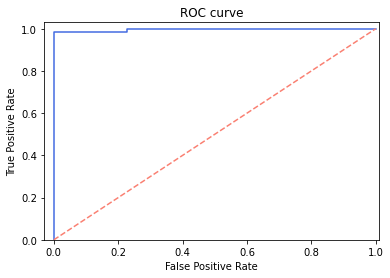

In [31]:
# Test our funtion with probability from logistic regression
probabilities = logreg.predict_proba(X_test)[:,1]
manual_roc(probabilities)

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer: Unbalance classes are generally problem because non-CKD will not usually come to the clinic. So, we will have few data of non-CKD and the model that train with unbalance data may not have good performance for predicting non-CKD. 

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer: We don't have enough case for predicting the CKD. Machine may predict with less accuracy.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [32]:
# bootstrapping the majority class
majority = df[df['class'] == 1]
sample_df = majority.sample(200000, replace=True, random_state=42)
sample_df = pd.concat([sample_df, df])
sample_df.shape

(200400, 20)

In [33]:
sample_df['class'].value_counts(normalize=True)

1    0.999251
0    0.000749
Name: class, dtype: float64

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [34]:
# Define X, y
X = sample_df.drop('class', axis = 1)
y = sample_df['class']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify= y)

# Instantiate
logreg_unbal = LogisticRegression(penalty='none', max_iter= 400)

# Fit or train model
logreg_unbal.fit(X_train,y_train)

# Model evaluation
print(f'Training accuracy: {round(logreg.score(X_train,y_train),4)}')
print(f'Testing accuracy: {round(logreg.score(X_test,y_test),4)}\n')
y_preds = logreg_unbal.predict(X_test)
print(f'{confusion_matrix(y_test,y_preds)}\n')
print(classification_report(y_test, y_preds))


Training accuracy: 0.9678
Testing accuracy: 0.9683

[[   24    14]
 [    0 50062]]

              precision    recall  f1-score   support

           0       1.00      0.63      0.77        38
           1       1.00      1.00      1.00     50062

    accuracy                           1.00     50100
   macro avg       1.00      0.82      0.89     50100
weighted avg       1.00      1.00      1.00     50100



In [35]:
# The logistic regression model can't predict non-CKD class correctly in unbalance data.
# The recall of non-CKD in non-balanced data is only 63%. 

# Compare to model with our original data which has balance data (60/40), the model can predict almost all of non-CKD.
# The recall of non-CKD in balanced data is 100%

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!